# Processing Sequences Using RNNs and CNNs

In this chapter we will discuss recurrent neural networks (RNNs), a class of nets that can predict the future (well, up to a point, of course). They can analyze time series data such as stock prices and tell you when to buy or sell. In autonomous driving systems, they can anticipate car trajectories and help avoid accidents. More generally, they can work on sequences of arbitrary lengths, rather than on fixed-sized inputs like all the nets we have considered so far. For example, they can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing applications such as automatic translation or speech-to-text.

The two main difficulties that RNNs face are:
1. Unstable gradients, which can be alleviated using various techniques, including recurrent dropout and recurrent layer normalization
2. A (very) limited short-term memory, which can be extended using LSTM or GRU cells

RNNs are not the only types of neural networks capable of handling sequential data: for small sequences, such as audio samples or text, convolutional neural networks can actually work quite well too.

## Recurrent Neurons and Layers

Up to now we have focused on feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer. A recurrent neural network looks very much like a feedforward network, except it also has connections pointing backward. You can easily create a layer of recurrent neurons. At each time step $t$, every neuron receives both the input vector $x_{(t)}$ and the output vector from the previous time step $y_{(t-1)}$. Each recurrent neuron has two sets of weights: one for the inputs $x_{(t)}$ and the other for the outputs of the previous time step $y_{(t-1)}$. 

Note that many researchers prefer to use the hyperbolic tangent (tanh) activation function in RNNs rather than the ReLU activation function. 

## Memory Cells

Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of *memory*. A part of a neural network that preserves some state across time steps is called a *memory cell*.

## Input and Output Sequences

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs. This type of **sequence-to-sequence network** is useful for predicting time series such as stock prices. A **sequence-to-vector network** is useful for tasks like feeding the network a sequence of words corresponding to a movie review and the network would output a sentiment score from -1 to 1. Conversely, you can feed the network some input vector over and over again at each time step and let it ouptut a sequence. This is a **vector-to-sequence network**. For example, the input could be an image and the output could be caption for that image. Lastly, you could have a **sequence-to-vector network** called an **encoder** *followed by* a **vector-to-sequence network**, called a **decoder**, which is useful for tasks like translating a sentence from one language to another. 

## Training RNNs

To train an RNN, the trick is to unroll it through time and then simply use regular backpropagation. This strategy is called *backpropagation through time (BPTT)*. 

Just like in regular backpropagation, there is a first forward pass through the unrolled network then the output sequence is evaluated using a cost function. Note that this cost function may ignore some outputs (for example, in a sequence-to-vector RNN, all outputs are ignored except the very last one). The gradients of that cost function are then propagated backward through the unrolled network. Finally the model parameters are updated using the gradients computed during BPTT. Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output.

## Forecasting a Time Series

Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company's financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step. This is called a *time series*. In the first two examples there is a single value per time step, so these are *univariate time series*, while in the financial exmaple there are multiple values per time step, so it is a *multivariate time series*. A typical tasks is to predict future values, which is called *forecasting*. Another common task is to fill in the blanks: to predict (or rather 'postdict') missing values from the past. This is called *imputation*.

In [16]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

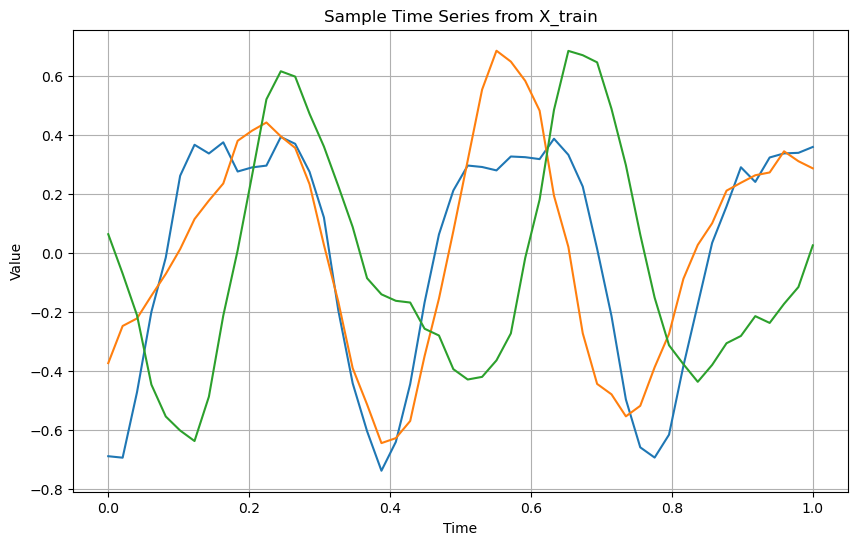

In [17]:
import matplotlib.pyplot as plt

# Select a few samples to plot (e.g., first 3)
n_samples_to_plot = 3
time = np.linspace(0, 1, n_steps)  # Time axis for X_train

plt.figure(figsize=(10, 6))
for i in range(n_samples_to_plot):
    plt.plot(time, X_train[i, :, 0], label=f'Series {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sample Time Series from X_train')
plt.grid(True)
plt.show()

**When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [batch_size, time_steps, dimensionality], where dimensionality is 1 for univariate time series and more than 1 for multivariate time series**

## Baseline Metrics

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series. This is called *naive forecasting*, and it is sometimes surprisingly difficult to outperform.

In [18]:
import tensorflow as tf

y_pred = X_valid[:, -1]
np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred))

0.021810627

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Input, Dense

model = Sequential([
    Input([50, 1]),
    Flatten(),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20)
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 0s 916us/step - loss: 0.0894
Epoch 2/20
219/219 [==============================] - 0s 972us/step - loss: 0.0234
Epoch 3/20
219/219 [==============================] - 0s 949us/step - loss: 0.0165
Epoch 4/20
219/219 [==============================] - 0s 904us/step - loss: 0.0137
Epoch 5/20
219/219 [==============================] - 0s 931us/step - loss: 0.0117
Epoch 6/20
219/219 [==============================] - 0s 931us/step - loss: 0.0101
Epoch 7/20
219/219 [==============================] - 0s 918us/step - loss: 0.0088
Epoch 8/20
219/219 [==============================] - 0s 982us/step - loss: 0.0076
Epoch 9/20
219/219 [==============================] - 0s 979us/step - loss: 0.0067
Epoch 10/20
219/219 [==============================] - 0s 947us/step - loss: 0.0060
Epoch 11/20
219/219 [==============================] - 0s 957us/step - loss: 0.0054
Epoch 12/20
219/219 [==============================] - 0s 929us/step - loss: 0.0050
E

0.0036782212555408478

## Implementing a Simple RNN

In [27]:
from tensorflow.keras.layers import SimpleRNN

model = Sequential([
    Input(shape=[None, 1]),
    SimpleRNN(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20)
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.3008
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1818
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0885
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0466
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0349
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0312
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0288
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0268
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0250
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0233
Epoch 11/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0218
Epoch 12/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0205
Epoch 13/20
219/219 [====

0.014045407995581627

We do not need to specify the length of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to None). By default, the SimpleRNN layer uses the hyperbolic tangent activation function. It works exactly as we saw earlier: the initial state $h_{init}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step $x_{0}$. The neuron computes a weighted sum of these values and applies the hyperbolic tangent functionto the result, and this gives the first output, $y_{0}$. In a simple RNN, this output is also the new state $h_{0}$. This new state is passed to the same recurrent neuron along wit hthe next input value $x_{1}$, and the process is repeated until the las time step. Then the layer just outputs the last value, $y_{49}$. All of this is performed simultaneously for every time series.

By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set return_sequences=True.

Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that's a total of 51 parameters). In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that's just the numer of recurrent neurons in the layer), plust a bias term. In this simple RNN, that's a total of just three parameters.

## Trend and Seasonality

There are many other models to forecast time series, such as *weighted moving average* models or *autoregressive integrated moving average (ARIMA)* models. **Some of them require you to first remove the trend and seasonality**. For example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would have to remove this trend from the time series. One the model is trained and starts making predictions, you would have toa dd the trend back to get the final predictions. Similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe strong seasonality: since it sells well every summer, a similar patter will be repeated every year. You would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and teh value one year earlier (this technique is called *differencing*). Again, after the model is trained and makes predictions, you would have to add the seasonal pattern back to get the final predictions.

**When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the trend or the seasonality**

## Deep RNNs